# Classifying Images using Dropout and Batchnorm Layer

## Introduction

In this notebook, you learn how to build a neural network to classify the tf-flowers dataset using dropout and batchnorm layer.

## Learning objectives

* Define Helper Functions.
* Apply dropout and batchnorm layer.


Each learning objective will correspond to a __#TODO__ in the student lab notebook -- try to complete this notebook first and then review the [solution notebook](../solutions/classifying_images_using_dropout_and_batchnorm_layer.ipynb).


In [1]:
import tensorflow as tf
print(tf.version.VERSION)

2.6.5


## Define Helper Functions
#### Reading and Preprocessing image data

In [2]:
# Helper functions
def training_plot(metrics, history):
  f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
  for idx, metric in enumerate(metrics):
    ax[idx].plot(history.history[metric], ls='dashed')
    ax[idx].set_xlabel("Epochs")
    ax[idx].set_ylabel(metric)
    ax[idx].plot(history.history['val_' + metric]);
    ax[idx].legend([metric, 'val_' + metric])

# Call model.predict() on a few images in the evaluation dataset
def plot_predictions(filename):
  f, ax = plt.subplots(3, 5, figsize=(25,15))
  dataset = (tf.data.TextLineDataset(filename).
      map(decode_csv))
  for idx, (img, label) in enumerate(dataset.take(15)):
    ax[idx//5, idx%5].imshow((img.numpy()));
    batch_image = tf.reshape(img, [1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
    batch_pred = model.predict(batch_image)
    pred = batch_pred[0]
    label = CLASS_NAMES[label.numpy()]
    pred_label_index = tf.math.argmax(pred).numpy()
    pred_label = CLASS_NAMES[pred_label_index]
    prob = pred[pred_label_index]
    ax[idx//5, idx%5].set_title('{}: {} ({:.4f})'.format(label, pred_label, prob))

def show_trained_weights(model):
  # CLASS_NAMES is ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
  LAYER = 1 # Layer 0 flattens the image, layer=1 is the first dense layer
  WEIGHT_TYPE = 0 # 0 for weight, 1 for bias

  f, ax = plt.subplots(1, 5, figsize=(15,15))
  for flower in range(len(CLASS_NAMES)):
    weights = model.layers[LAYER].get_weights()[WEIGHT_TYPE][:, flower]
    min_wt = tf.math.reduce_min(weights).numpy()
    max_wt = tf.math.reduce_max(weights).numpy()
    flower_name = CLASS_NAMES[flower]
    print("Scaling weights for {} in {} to {}".format(
        flower_name, min_wt, max_wt))
    weights = (weights - min_wt)/(max_wt - min_wt)
    ax[flower].imshow(weights.reshape(IMG_HEIGHT, IMG_WIDTH, 3));
    ax[flower].set_title(flower_name);

In [4]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3

def read_and_decode(filename, reshape_dims):
  # Read the file
  img = tf.io.read_file(filename)
  # Convert the compressed string to a 3D uint8 tensor.
  img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)

  # Resize the image to the desired size.
  # TODO 1 -- Your code here
  return tf.image.resize(img, reshape_dims)

CLASS_NAMES = [item.numpy().decode("utf-8") for item in 
               tf.strings.regex_replace(
                 tf.io.gfile.glob("gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/*"),
                 "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/", "")]
CLASS_NAMES = [item for item in CLASS_NAMES if item.find(".") == -1]
print("These are the available classes:", CLASS_NAMES)

# the label is the index into CLASS_NAMES array
def decode_csv(csv_row):
  record_defaults = ["path", "flower"]
  filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string))
  return img, label

These are the available classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Apply dropout and batchnorm layer
A deep neural network (DNN) is a neural network with more than one hidden layer. Each time you add a layer, the number of trainable parameters increases. Therefore,you need a larger dataset. You still have only 3700 flower images which might cause overfitting.


Dropouts are the regularization technique that is used to prevent overfitting in the model. Batch normalization is a layer that allows every layer of the network to do learning more independently. The layer is added to the sequential model to standardize the input or the outputs. Add a dropout and batchnorm layer after each of the hidden layers.

#### Dropout
Dropout is one of the oldest regularization techniques in deep learning. At each training iteration, it drops random neurons from the network with a probability p (typically 25% to 50%). In practice, neuron outputs are set to 0. The net result is that these neurons will not participate in the loss computation this time around and they will not get weight updates. Different neurons will be dropped at each training iteration.
#### Batch normalization
Our input pixel values are in the range [0,1] and this is compatible with the dynamic range of the typical activation functions and optimizers. However, once we add a hidden layer, the resulting output values will no longer lie in the dynamic range of the activation function for subsequent layers. When this happens, the neuron output is zero, and because there is no difference by moving a small amount in either direction, the gradient is zero. There is no way for the network to escape from the dead zone. To fix this, batch norm normalizes neuron outputs across a training batch of data, i.e. it subtracts the average and divides by the standard deviation. This way, the network decides, through machine learning, how much centering and re-scaling to apply at each neuron. In Keras, you can selectively use one or the other:

`tf.keras.layers.BatchNormalization(scale=False, center=True)`

When using batch normalization, remember that:
1. Batch normalization goes between the output of a layer and its activation function. So, rather than set activation='relu' in the Dense layer’s constructor, we’d omit the activation function, and then add a separate Activation layer.
2. If you use center=True in batch norm, you do not need biases in your layer. The batch norm offset plays the role of a bias.
3. If you use an activation function that is scale-invariant (i.e. does not change shape if you zoom in on it) then you can set scale=False. ReLu is scale-invariant. Sigmoid is not.

In [7]:
def train_and_evaluate(batch_size = 32,
                       lrate = 0.0001,
                       l1 = 0,
                       l2 = 0.001,
                       dropout_prob = 0.4,
                       num_hidden = [64, 16]):
  regularizer = tf.keras.regularizers.l1_l2(l1, l2)

  train_dataset = (tf.data.TextLineDataset(
      "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv").
      map(decode_csv)).batch(batch_size)

  eval_dataset = (tf.data.TextLineDataset(
      "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv").
      map(decode_csv)).batch(32) # this doesn't matter

  # NN with multiple hidden layers
  layers = [tf.keras.layers.Flatten(
      input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
      name='input_pixels')]
  for hno, nodes in enumerate(num_hidden):
    layers.extend([
      tf.keras.layers.Dense(nodes,
                            kernel_regularizer=regularizer, 
                            name='hidden_dense_{}'.format(hno)),
      tf.keras.layers.BatchNormalization(scale=False, # ReLU
                                         center=False, # have bias in Dense
                                         name='batchnorm_dense_{}'.format(hno)),
      #move activation to come after batchnorm
      tf.keras.layers.Activation('relu', name='relu_dense_{}'.format(hno)),

  # TODO 2 -- Your code here
      tf.keras.layers.Dropout(rate=dropout_prob, name=f"dropout_dense_{hno}"),
    ])

  layers.append(
      tf.keras.layers.Dense(len(CLASS_NAMES), 
                            kernel_regularizer=regularizer,
                            activation='softmax',
                            name='flower_prob')
  )

  model = tf.keras.Sequential(layers, name='flower_classification')
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(
                    from_logits=False),
                metrics=['accuracy'])
  print(model.summary())
  history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10)
  training_plot(['loss', 'accuracy'], history)
  return model

Model: "flower_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_pixels (Flatten)       (None, 150528)            0         
_________________________________________________________________
hidden_dense_0 (Dense)       (None, 64)                9633856   
_________________________________________________________________
batchnorm_dense_0 (BatchNorm (None, 64)                128       
_________________________________________________________________
relu_dense_0 (Activation)    (None, 64)                0         
_________________________________________________________________
dropout_dense_0 (Dropout)    (None, 64)                0         
_________________________________________________________________
hidden_dense_1 (Dense)       (None, 16)                1040      
_________________________________________________________________
batchnorm_dense_1 (BatchNorm (None, 16)      

2024-06-23 03:50:34.456696: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


104/104 [==============================] - 76s 718ms/step - loss: 1.8963 - accuracy: 0.2727 - val_loss: 1.9139 - val_accuracy: 0.3351
Epoch 2/10
104/104 [==============================] - 74s 711ms/step - loss: 1.7532 - accuracy: 0.3215 - val_loss: 1.5687 - val_accuracy: 0.3892
Epoch 3/10
104/104 [==============================] - 74s 712ms/step - loss: 1.6489 - accuracy: 0.3645 - val_loss: 1.4982 - val_accuracy: 0.4405
Epoch 4/10
104/104 [==============================] - 74s 712ms/step - loss: 1.6166 - accuracy: 0.3655 - val_loss: 1.5285 - val_accuracy: 0.4622
Epoch 5/10
104/104 [==============================] - 74s 711ms/step - loss: 1.5859 - accuracy: 0.3794 - val_loss: 1.5067 - val_accuracy: 0.4514
Epoch 6/10
104/104 [==============================] - 73s 706ms/step - loss: 1.5440 - accuracy: 0.4112 - val_loss: 1.5604 - val_accuracy: 0.3568
Epoch 7/10
104/104 [==============================] - 73s 697ms/step - loss: 1.5149 - accuracy: 0.4115 - val_loss: 1.5135 - val_accuracy: 0.4

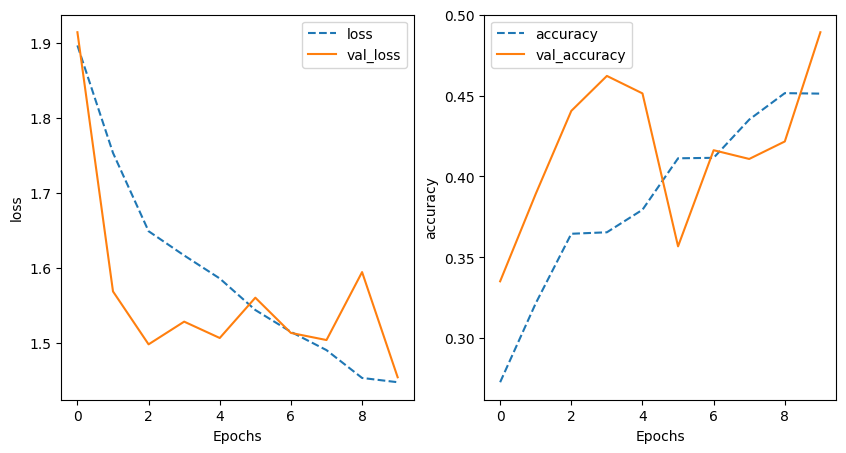

In [8]:
model = train_and_evaluate(dropout_prob=0.4)

Congrats! You've completed the lab!